# Afficher l'heure et la météo au moment de la requête du cycliste

In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### L'heure et la date en temps réel

In [3]:
##L'heure et la date de la requête : 
import time
import datetime
#On regarde l'heure et la date de la requête
time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) #Date et heure en entier
Date = time.strftime('%Y-%m-%d', time.localtime())
Date_Eur = time.strftime('%d-%m-%Y', time.localtime())
Time = time.strftime('%H:%M', time.localtime()) #Heure uniquement
DateTime = time.strftime('%Y-%m-%dT%H:%M:%S', time.localtime()) 
# Pour faciliter ici, je n'ai pas arrondi les minutes, mais rogné
print("Aujourd'hui nous sommes le", Date_Eur)

Aujourd'hui nous sommes le 13-12-2020


### Les heures de lever et de coucher du soleil : 


Difficulté pour trouver une base de donnée propre : seulement à télécharger par année
On prend la base de donnée sur le site : http://ptaff.ca/, et je l'ai mise sur Github

In [5]:
heures_soleil = pd.read_csv('https://raw.githubusercontent.com/ImaneFa/Projet_Python/main/lever_coucher_soleil.csv',  sep = ',')
heures_soleil.loc[heures_soleil['Date'] == Date] 

,Date,Lever_du_soleil,Coucher_du_soleil,Durée_du_jour
347,2020-12-13,08:36,16:54,08:18


In [6]:
heures_soleil.loc[heures_soleil['Date'] == Date]
if  Time >=heures_soleil.loc[heures_soleil['Date'] == Date]['Lever_du_soleil'].any() and Time <=heures_soleil.loc[heures_soleil['Date'] == Date]['Coucher_du_soleil'].any():
    print('Il est', Time,', vous roulez de jour.')
else: 
    print('Il est', Time,'attention, vous roulez de nuit.')

Il est 15:52 , vous roulez de jour.


### La météo en temps réel

Sur le site : https://www.data.gouv.fr/fr/datasets/prevision-meteo-ile-de-france-arome/#_ on prélève la seule base de donnée gratuite d'internet avec les prévisions pour les 36h après sa mise à jour


In [4]:
meteo_gpd = 'https://www.data.gouv.fr/fr/datasets/r/8e834f69-0b43-439a-87bd-87ca80c84cd7'
meteo_idf = gpd.read_file(meteo_gpd)

In [5]:
meteo_idf = meteo_idf[['timestamp', 'forecast', '2_metre_temperature', 'total_water_precipitation',  'geometry']]
meteo_idf = meteo_idf.sort_values('forecast')

D'après la documentation, 

- La colonne _"total_water_precipitation"_ correspond au cumul (depuis le début de la simulation) de la somme des flux au sol des précipitations liquides et solides (eau, neige, grêlons) en kg/m²
- La colonne _"2_metre_temperature"_ correspond à la température diagnostiquée à 2m de hauteur au dessus du relief

In [6]:
#Différence en minutes entre la prévision et l'heure prévue
meteo_idf["duration"] = pd.to_datetime(meteo_idf["forecast"]) - pd.to_datetime(meteo_idf["timestamp"])
meteo_idf["duration"] = meteo_idf["duration"].astype("timedelta64[m]") 
#On ne conserve que les prévisions pour le centre de Paris en les supposant signifiantes pour toute l'Ile-de-France
meteo_idf = meteo_idf.cx[2.35,48.85] 

In [7]:
meteo_idf = meteo_idf.reset_index()

In [8]:
for i in range(1,len(meteo_idf)):
    meteo_idf.loc[i, 'diff_precipitation'] = meteo_idf.loc[i,'total_water_precipitation']-meteo_idf.loc[i-1,'total_water_precipitation']

#Parfois des erreurs dans la conception des données, lorsque "duree" est négative (impossible car signifierait que la somme des précipitations diminue dans le temps)
#Pour négliger ces erreurs, on remplace les valeurs négatives par 0
meteo_idf.loc[(meteo_idf["diff_precipitation"]<0), "diff_precipitation"] = 0

In [9]:
#On trouve la durée de l'intervalle entre deux estimations
for i in range(1,len(meteo_idf)):
    meteo_idf.loc[i, 'duree_intervalle'] = meteo_idf.loc[i,'duration']-meteo_idf.loc[i-1,'duration']

Conversion des données de précipitations en kg/m² en données mesurées en mm/h :
On a 1L/m² =1mm, et 1kg d'eau = 1L d'eau, d'où : 
- précipitation en 1h = (précipitations pendant l'intervalle)/(duree intervalle)*60 

La manière de mesurer les précipitations la plus répandue est la pluviométrie, qui correspond à la hauteur d'eau recueillie sur une surface plane (exprimée en mm). 
On sépare l'intensité de la pluie : 
- pluie très faible et négligeable  (de 0 à 2 mm/h)
- modérée et forte (plus 2 mm/h)

In [10]:
meteo_idf["precipitations mm/h"] = ((meteo_idf["diff_precipitation"])/(meteo_idf["duree_intervalle"]))*60
meteo_idf = meteo_idf[['forecast', '2_metre_temperature','precipitations mm/h']]

In [11]:
meteo_idf_temps_reel = meteo_idf.loc[meteo_idf['forecast'] <= DateTime][['forecast', '2_metre_temperature', 'precipitations mm/h' ]].sort_values('forecast').tail(1)
# On fait en rognant l'heure et non en approximant => voir si améliorable ou pas
meteo_idf_temps_reel

,forecast,2_metre_temperature,precipitations mm/h
15,2020-12-13T19:00:00,7.549463,0.0


On compare la météo actuelle par rapport aux accidents enregistrés

In [12]:
accident_velo = pd.read_csv('https://www.data.gouv.fr/fr/datasets/r/3d5f2317-5afd-4a9f-a9c5-bd4fe0113f39')
accident_velo_idf = accident_velo[accident_velo['departement'].isin(['75','77','78','91','92','93','94','95'])]
# Il y a un problème avec les latitudes et les longitudes nulles et les quelques erreurs

C:\Users\Vinciane\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (5,6,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
accident_velo_idf_meteo = accident_velo_idf[['identifiant accident','date','mois', 'jour', 'heure', 'departement','luminosite', 'conditions atmosperiques', 'etat surface', 'sexe', 'age', 'gravite accident', 'commune', ]]
accident_velo_idf_meteo

,identifiant accident,date,mois,jour,heure,departement,luminosite,conditions atmosperiques,etat surface,sexe,age,gravite accident,commune
58,200500001606,2005-01-13,01 - janvier,3 - jeudi,11.0,78,Plein jour,Normale,normale,M,61-62,2 - Blessé hospitalisé,78230
61,200500001930,2005-01-15,01 - janvier,5 - samedi,15.0,95,Plein jour,Normale,normale,M,58-59,0 - Indemne,95042
221,200500004591,2005-01-04,01 - janvier,1 - mardi,17.0,75,Nuit avec éclairage public allumé,Normale,normale,M,36-37,1 - Blessé léger,75001
222,200500004597,2005-01-03,01 - janvier,0 - lundi,9.0,75,Plein jour,Normale,normale,M,26-27,0 - Indemne,75005
223,200500004600,2005-01-03,01 - janvier,0 - lundi,17.0,75,Nuit avec éclairage public allumé,Normale,normale,M,31-32,0 - Indemne,75019
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,201800050291,2018-07-10,07 - juillet,1 - mardi,9.0,75,Plein jour,Normale,normale,F,58-59,2 - Blessé hospitalisé,75101
65532,201800050337,2018-11-17,11 - novembre,5 - samedi,12.0,75,Plein jour,Normale,normale,M,59-60,1 - Blessé léger,75101
65533,201800050355,2018-02-01,02 - février,3 - jeudi,15.0,75,Plein jour,Temps couvert,mouillée,M,31-32,1 - Blessé léger,75102
65534,201800050359,2018-02-12,02 - février,0 - lundi,9.0,75,Plein jour,Normale,normale,F,29-30,1 - Blessé léger,75101


In [14]:
accident_velo_idf_meteo['conditions atmosperiques'] = accident_velo_idf_meteo['conditions atmosperiques'].apply(
    lambda x: "Normale" if x == 'Normale' or x =='Temps éblouissant' or x== 'Autre' else x).apply(
    lambda x: "Couvert" if x == 'Brouillard - fumée' or x =='Temps couvert' else x).apply (
    lambda x: "Précipitations" if x == 'Pluie forte' or x == 'Pluie légère' or x =='Neige - grêle' or x =='Vent fort - tempête' else x)

accident_velo_idf_meteo['luminosite'] = accident_velo_idf_meteo['luminosite'].apply(
    lambda x: "Jour" if x == 'Plein jour' else x).apply(
    lambda x: "Nuit" if x == "Crépuscule ou aube" or x == 'Nuit avec éclairage public allumé' or x=='Nuit avec éclairage public non allumé' or x=='Nuit sans éclairage public' else x)

C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `item` has been deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Vinciane\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: `item` has been deprecated and will be removed in a future version
  """


Quel chanceux, il n'y a ni pluie ni verglas pour votre trajet à vélo.
Pourtant, il faut quand même faire attention, car de nombreux accidents ont lieu dans des conditions atmosphériques normales.


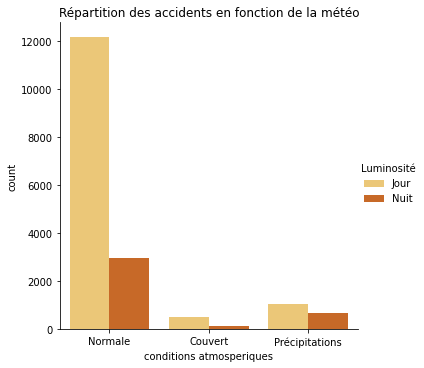

In [15]:
if meteo_idf_temps_reel['precipitations mm/h'].item()> 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print("Attention il pleut et il y a peut-être du verglas sur la chaussée.")
elif meteo_idf_temps_reel['precipitations mm/h'].item() > 2.000 and (meteo_idf_temps_reel['2_metre_temperature'].item() < -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) > 1:
    print("Attention il pleut, mais normalement, il n'y a pas de verglas sur la chaussée.")
elif meteo_idf_temps_reel['precipitations mm/h'].item() < 2.00 and (meteo_idf_temps_reel['2_metre_temperature'].item() > -1 or meteo_idf_temps_reel['2_metre_temperature'].item()) < 1:
    print("Il ne pleut pas, mais attention, il peut y avoir du verglas sur votre trajet.")
else:
    print("Quel chanceux, il n'y a ni pluie ni verglas pour votre trajet à vélo.")
    print("Pourtant, il faut quand même faire attention, car de nombreux accidents ont lieu dans des conditions atmosphériques normales.")
    category_order = ['Normale', 'Couvert', 'Précipitations']

    g = sns.catplot(x='conditions atmosperiques',
            hue = 'luminosite', palette="YlOrBr", 
            data=accident_velo_idf_meteo, kind='count', order=category_order);

    plt.title('Répartition des accidents en fonction de la météo')
    g._legend.set_title('Luminosité')

    plt.show()